<a href="https://colab.research.google.com/github/mallang327/EEE4178-Hands-On/blob/main/Day4_2022_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Day4 - RNN / LSTM / GRU

### 1. RNN

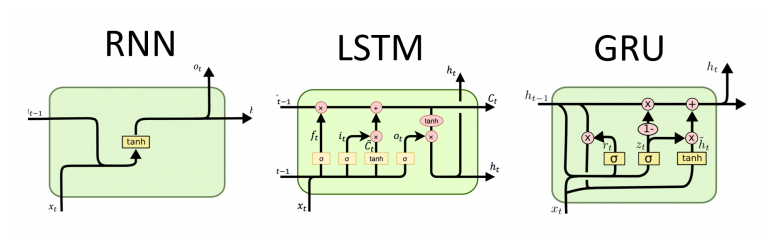

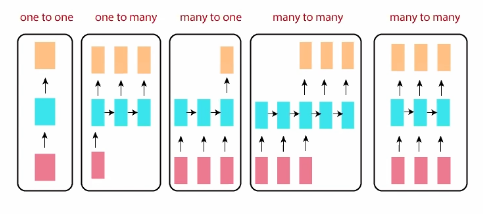
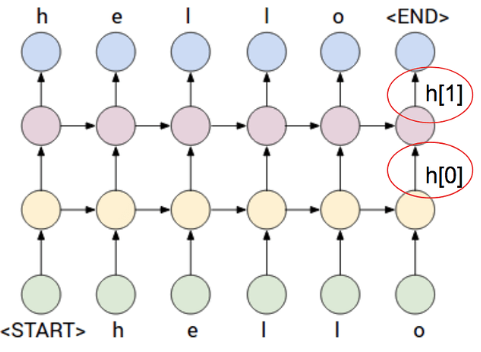

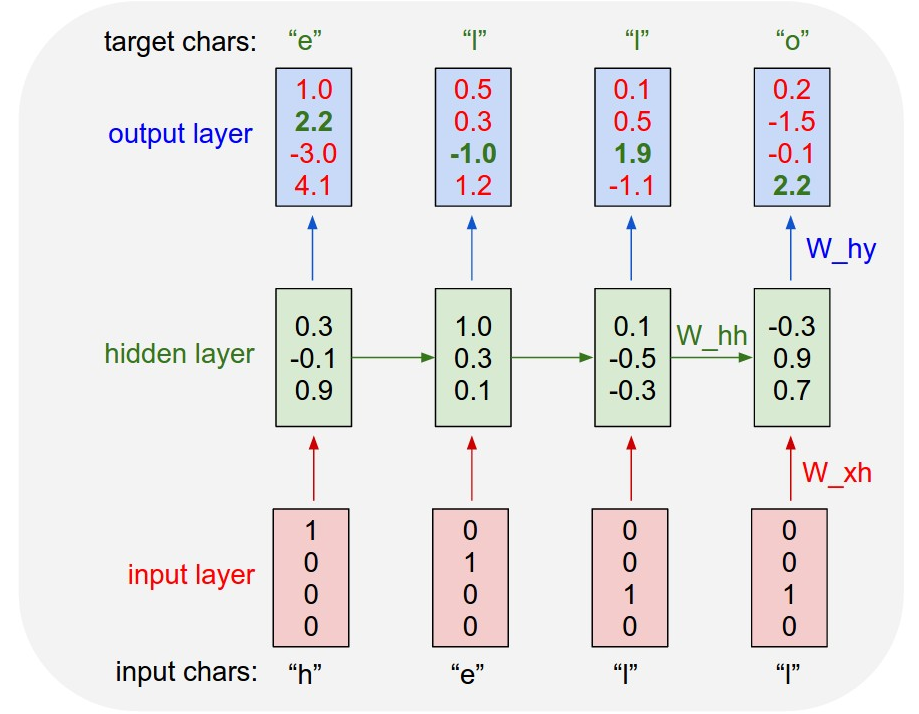

### 2. IMDB Dataset (영화 리뷰 데이터셋)

#### Import Libraries

In [ ]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

# Preprocess Text data
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

import pdb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!gdown https://drive.google.com/uc?id=11QEkMQN3nOhnVb1pl2O1NFdE9yEX3OmI

Downloading...
From: https://drive.google.com/uc?id=11QEkMQN3nOhnVb1pl2O1NFdE9yEX3OmI
To: /content/imdb_processed.csv
100% 45.1M/45.1M [00:00<00:00, 76.5MB/s]


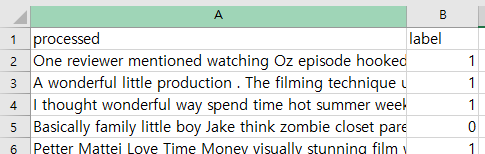

imdb_processed.csv

processed -> 영화 리뷰 내용

label -> 긍정: 1 / 부정: 0

In [ ]:
# read data
data = pd.read_csv('./imdb_processed.csv')
# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()
# check our list
words[:10]

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right']

In [ ]:
# build vocabulary [단어 사전화]
counter = Counter(words) # 전체 단어들이 나온 횟수를 딕셔너리화
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [ ]:
print(f"전체 단어 수: {len(words)}, 중복 단어 제거 후 --> {len(word2int)}")

전체 단어 수: 7888384, 중복 단어 제거 후 --> 121301


In [ ]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████| 50000/50000 [00:02<00:00, 23911.32it/s]


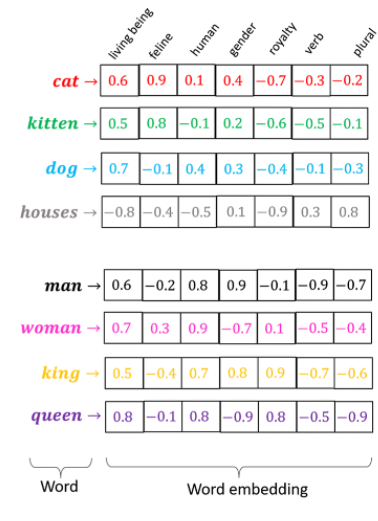

In [ ]:
# print first-10 words of 5 reviews
for i in range(6,10):
    print(reviews_enc[i][:10])

[3, 197, 18, 10, 21, 12517, 1904, 55922, 121, 5112]
[14, 31, 427, 2, 1342, 4021, 165, 34, 2960, 1]
[47893, 980, 359, 6, 3, 180, 776, 81, 6, 1]
[64, 10, 125, 2269, 5606, 1980, 10, 5, 1, 64]


In [ ]:
print(f"{reviews[6]}\n\n{reviews[7]}\n\n{reviews[8]}\n\n{reviews[9]}")

I sure would like see resurrection dated Seahunt series tech today would bring back kid excitement . I grew black white TV Seahunt Gunsmoke hero every week . You vote comeback new sea hunt . We need change pace TV would work world water adventure . Oh way thank outlet like view many viewpoint TV many movie . So ole way I believe I got I wan na say . Would nice read plus point sea hunt . If rhyme would line would let submit , leave doubt quit , If I must go let .

This show amazing , fresh innovative idea first aired . The first year brilliant , thing dropped . By , show really funny anymore , continued decline complete waste time today . It truly disgraceful far show fallen . The writing painfully bad , performance almost bad - mildly entertaining respite guest - host , show probably still air . I find hard believe creator hand - selected original cast also chose band hack followed . How one recognize brilliance see fit replace mediocrity ? I felt I must give star respect original cast

In [ ]:
# padding sequences [RNN input의 길이를 같게 맞춰주기 위해 짧은 문장을 zero padding, 긴 문장은 trim]
def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

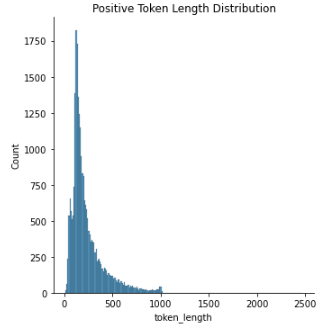 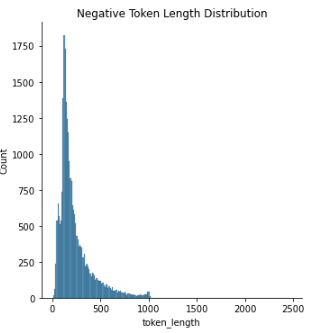

In [ ]:
features[6]

In [ ]:
# get labels as numpy
labels = data.label.to_numpy()

#### Split Dataset

In [ ]:
# train test split
train_size = 0.7     # csv파일에 있는 Dataset 50,000개 중 35,000개를 train으로 사용
val_size = 0.5       # 나머지 15,000개 중 절반인 7,500개를 validation & 7,500개는 test set으로 사용

# make train set
split_id = int(len(features) * train_size) # len(features) = 50000 / split_id = ?
train_x, remain_x = features[:split_id], features[split_id:] # len(train_x) = ? / len(remain_x) = ?
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size) # len(remain_x) = ? / split_val_id = ?
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:] # len(val_x) = ?
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [ ]:
# Check positive & negative data balance
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

17510 17490
3753 3747
3737 3763


### 3. DataLoader

In [ ]:
# define batch size # RuntimeError: CUDA out of memory 에러 출력 시 batch_size 낮추고 실행
batch_size = 128

# create tensor datasets
train_set = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_set = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_set = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(valid_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

### 4. Model 구현

In [ ]:
# Model Architecture
class Sentiment(nn.Module):
  def __init__(self, num_vocab, embedding_dim, hidden_dim, num_layers, out_node, drop_percent=0.2):
    super(Sentiment, self).__init__()

    self.num_vocab = num_vocab
    # Input sentence to Vector Representation
    self.embed = nn.Embedding(num_embeddings=num_vocab, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    #self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
    self.dropout = nn.Dropout(drop_percent)
    self.fc = nn.Linear(hidden_dim, out_node) 
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):

    x = x.long()
    x = self.embed(x)
    out, _ = self.lstm(x)
    #out, _ = self.gru(x)
    out = self.dropout(out)
    out = self.fc(out[:,-1,:])
    out = self.sigmoid(out)
    return out

In [ ]:
# Model Hyperparamters
vocab_size = len(word2int)
out_node = 1
embedding_dim = 256
hidden_dim = 512
num_layers = 2
dropout = 0.25
learning_rate = 0.001
num_epochs = 8

In [ ]:
# model initialization
model = Sentiment(vocab_size, embedding_dim, hidden_dim, num_layers, out_node, dropout)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. Train & Evaluate

In [ ]:
# Train Loop
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []

best_valid_loss = torch.inf
best_epoch = 0
model = model.to(device)
epochloop = tqdm(range(num_epochs), position=0, desc='Training', leave=True)
for epoch in epochloop:
  model.train()
  train_loss = 0
  train_acc = 0

  ## Train
  for idx, (text, label) in enumerate(train_loader):
    epochloop.set_postfix_str(f'Training batch {idx}/{len(train_loader)}') # visualize
    text, label = text.to(device), label.to(device)
    
    out = model(text).squeeze(1)
    # acc
    train_acc += (torch.round(out).squeeze()==label.float()).sum()
    
    # loss
    optimizer.zero_grad()
    loss = criterion(out.squeeze(), label.float())
    train_loss += loss.item()
    loss.backward()
    optimizer.step()   

  ## Validation
  model.eval()
  val_loss = 0
  val_acc = 0

  with torch.no_grad():
      for idx, (text, label) in enumerate(val_loader):
          epochloop.set_postfix_str(f'Validation batch {idx}/{len(val_loader)}')
          text, label = text.to(device), label.to(device)

          # forward pass
          out = model(text)
          # acc
          val_acc += (torch.round(out).squeeze()==label.float()).sum()

          # loss
          loss = criterion(out.squeeze(), label.float())
          val_loss += loss.item()
  model.train()
  # save model if validation loss decrease
  if val_loss / len(valid_set) <= best_valid_loss:
      best_valid_loss = val_loss / len(val_loader)
      best_epoch = epoch
      torch.save(model.state_dict(), "LSTM_epoch_{}.pth".format(epoch))

  # print epoch loss & accuracy
  print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_set) * 100}% | Val Loss: {val_loss / len(val_loader):.3f} Val Acc: {val_acc / len(valid_set) * 100}%')
  tr_loss.append(train_loss / len(train_loader))
  tr_acc.append(train_acc.cpu().numpy() / len(train_set) * 100)
  v_loss.append(val_loss / len(val_loader))
  v_acc.append(val_acc.cpu().numpy() / len(valid_set) * 100)



Training:  12%|█▎        | 1/8 [00:10<01:12, 10.34s/it, Training batch 6/274]

Epoch 1/8 | Train Loss: 0.694 Train Acc: 49.97142791748047% | Val Loss: 0.693 Val Acc: 50.01333236694336%


Training:  25%|██▌       | 2/8 [00:19<00:57,  9.58s/it, Training batch 6/274]

Epoch 2/8 | Train Loss: 0.693 Train Acc: 50.81428146362305% | Val Loss: 0.692 Val Acc: 51.306663513183594%


Training:  38%|███▊      | 3/8 [00:28<00:46,  9.34s/it, Training batch 6/274]

Epoch 3/8 | Train Loss: 0.689 Train Acc: 51.33713912963867% | Val Loss: 0.692 Val Acc: 51.63999938964844%


Training:  50%|█████     | 4/8 [00:37<00:36,  9.25s/it, Training batch 6/274]

Epoch 4/8 | Train Loss: 0.589 Train Acc: 67.77143096923828% | Val Loss: 0.455 Val Acc: 79.7066650390625%


Training:  62%|██████▎   | 5/8 [00:46<00:27,  9.16s/it, Training batch 6/274]

Epoch 5/8 | Train Loss: 0.331 Train Acc: 86.64857482910156% | Val Loss: 0.365 Val Acc: 84.87999725341797%


Training:  75%|███████▌  | 6/8 [00:55<00:18,  9.16s/it, Training batch 6/274]

Epoch 6/8 | Train Loss: 0.213 Train Acc: 92.27999877929688% | Val Loss: 0.350 Val Acc: 86.23999786376953%


Training:  88%|████████▊ | 7/8 [01:05<00:09,  9.14s/it, Training batch 6/274]

Epoch 7/8 | Train Loss: 0.134 Train Acc: 95.6971435546875% | Val Loss: 0.375 Val Acc: 85.49333190917969%


Training: 100%|██████████| 8/8 [01:14<00:00,  9.27s/it, Validation batch 58/59]

Epoch 8/8 | Train Loss: 0.094 Train Acc: 97.17142486572266% | Val Loss: 0.461 Val Acc: 85.9866714477539%


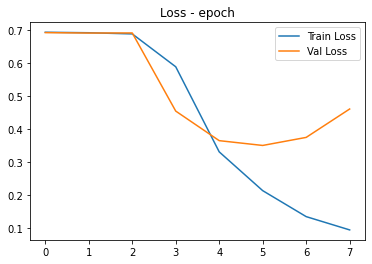

In [ ]:
plt.plot(range(num_epochs), tr_loss, label="Train Loss")
plt.plot(range(num_epochs), v_loss, label="Val Loss")
plt.legend()
plt.title("Loss - epoch")
plt.show()

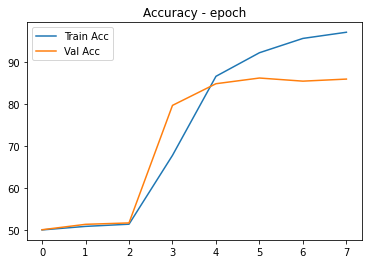

In [ ]:
plt.plot(range(num_epochs), tr_acc, label="Train Acc")
plt.plot(range(num_epochs), v_acc, label="Val Acc")
plt.legend()
plt.title("Accuracy - epoch")
plt.show()

### 6. Test

In [ ]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(test_loader, leave=True, desc='Inference')
with torch.no_grad():
    for text, label in testloop:
        text, label = text.to(device), label.to(device)

        # forward pass
        out = model(text)

        # acc
        test_acc += (torch.round(out).squeeze()==label.float()).sum()

        # loss
        loss = criterion(out.squeeze(), label.float())
        test_loss += loss.item()
    print("\n")
    print(f'Accuracy: {test_acc.cpu().numpy()/len(test_set) * 100}% / Loss: {test_loss/len(test_loader):.4f}')

Inference: 100%|██████████| 59/59 [00:00<00:00, 99.66it/s] 



Accuracy: 87.22666666666666% / Loss: 0.4304
